### Imports

In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
from neuropy.utils.misc import flatten
import subjects
from plotters import Plotter, stats_to_df, filter_stats_df, add_parametric_extras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Delta wave amplitude across session

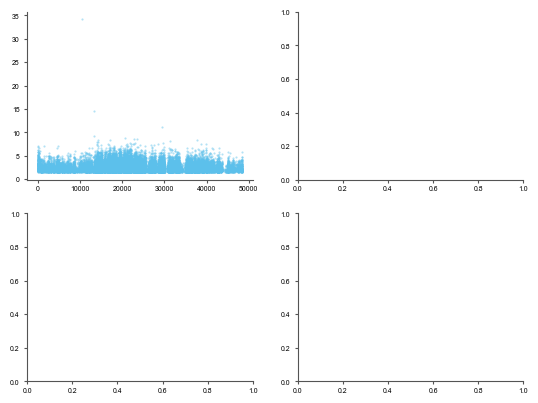

In [25]:
# sessions = subjects.ripple_sess()
sessions = subjects.nsd.ratUday2

_, axs = plt.subplots(2, 2)
axs = axs.reshape(-1)

for s, sess in enumerate(sessions):
    delta_df = sess.delta_wave.to_dataframe()
    delta_time = delta_df["peak_time"].values
    delta_amp = delta_df["peak_amp_zsc"].values

    axs[s].plot(delta_time, delta_amp, ".", markersize=1, alpha=0.5)

### Delta amplitude in 2.5 hour blocks

In [26]:
sessions = subjects.ripple_sess()

delta_df = []
for s, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs(include_maze=False)
    delta_wave = sess.delta_wave

    for e in zt_epochs.itertuples():
        e_waves = delta_wave.time_slice(e.start, e.stop).to_dataframe()
        mean_amp = e_waves["peak_amp_zsc"].values.mean()
        df = pd.DataFrame(
            {
                "delta_amp": [mean_amp],
                "zt": e.label,
                "session": s,
                "grp": sess.tag,
            }
        )
        delta_df.append(df)

delta_df = pd.concat(delta_df, ignore_index=True)

subjects.GroupData().save(delta_df, "delta_wave_amp_blocks")

delta_wave_amp_blocks saved


In [ ]:
fig = subjects.SdFig().fig1(3, 3)

ax = fig.subplot(fig.gs[0])

sns.stripplot(data=delta_df, x="zt", y="delta_amp", hue="grp", dodge=True)

### Delta rate in 2.5 hour blocks

In [5]:
zt_epochs

5 epochs
Snippet: 
      start     stop  label
0   1213.0  10213.0    PRE
1  10214.0  13364.0   MAZE
2  13365.0  22365.0  0-2.5
3  22365.0  31365.0  2.5-5
4  31365.0  40365.0  5-7.5

In [4]:
sessions = subjects.ripple_sess()
save_name = True  # save_name=False kept for legacy compatability with BG code
include_maze = True  # include_maze=False kept for legacy compatability with BG code

delta_df = []
for s, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs(include_maze=include_maze)
    delta_wave = sess.delta_wave

    for e in zt_epochs.itertuples():
        n_waves = delta_wave.time_slice(e.start, e.stop).n_epochs
        if not save_name:
            df = pd.DataFrame(
                {
                    "delta_rate": [n_waves / e.duration],
                    "zt": e.label,
                    "session": s,
                    "grp": sess.tag,
                }
            )
        else:
            df = pd.DataFrame(
                {
                    "delta_rate": [n_waves / e.duration],
                    "zt": e.label,
                    "session": s,
                    "grp": sess.tag,
                    "name": sess.name,
                }
            )
        delta_df.append(df)

delta_df = pd.concat(delta_df, ignore_index=True)

maze_append = "_wmaze" if include_maze else ""
if not save_name:
    subjects.GroupData().save(delta_df, f"delta_wave_rate{maze_append}")
else:
    subjects.GroupData().save(delta_df, f"delta_wave_rate_w_name{maze_append}")

delta_wave_rate_w_name_wmaze saved


In [6]:
delta_df

,delta_rate,zt,session,grp,name
0,0.063556,PRE,0,NSD,RatJDay2
1,0.031250,MAZE,0,NSD,RatJDay2
2,0.452444,0-2.5,0,NSD,RatJDay2
3,0.984333,2.5-5,0,NSD,RatJDay2
4,0.419000,5-7.5,0,NSD,RatJDay2
...,...,...,...,...,...
75,0.269778,PRE,15,SD,RatVDay2
76,0.077778,MAZE,15,SD,RatVDay2
77,0.138667,0-2.5,15,SD,RatVDay2
78,0.148889,2.5-5,15,SD,RatVDay2


In [ ]:
fig = subjects.SdFig().fig1(3, 3)

ax = fig.subplot(fig.gs[0])

sns.stripplot(data=delta_df, x="zt", y="delta_rate", hue="grp", dodge=True)

### EDF 2F-G: Delta-ripple probability psth across 2.5 hour block

In [65]:
# sess.get_zt_epochs().iloc[[0, 2, 3, 4],:]
sess.get_zt_epochs().to_dataframe().iloc[[0, 2, 3, 4],:]

,start,stop,label,duration
0,1213.0,10213.0,PRE,9000.0
2,13365.0,22365.0,0-2.5,9000.0
3,22365.0,31365.0,2.5-5,9000.0
4,31365.0,40365.0,5-7.5,9000.0


In [27]:
from hfuncs import get_ccg
from scipy.ndimage import gaussian_filter1d
include_pre = False

sessions = subjects.ripple_sess()

delta_rpl_df = []
delta_rpl_mod_df = []
for s, sess in enumerate(sessions):
    if not include_pre: # POST only
        zt_epochs = sess.get_zt_epochs()[2:]
    else:
        zt_epochs = sess.get_zt_epochs().to_dataframe().iloc[[0, 2, 3, 4],:]

    for e in zt_epochs.itertuples():
        period = [e.start, e.stop]
        sw = sess.delta_wave.time_slice(*period)
        rpls = sess.ripple.time_slice(*period)

        # peak_amp = sw.to_dataframe().peak_amp_zsc
        # end_amp = sw.to_dataframe().stop_amp_zsc
        # delta_amp = np.abs(peak_amp) + np.abs(end_amp)

        sw_t = sw.to_dataframe().peak_time
        rpl_t = rpls.to_dataframe().peak_time

        t, ccg = get_ccg(sw_t, rpl_t, 0.010, 1)
        nsw = len(sw_t)  # number of slow/delta waves
        prob = ccg / nsw
        # ccg = gaussian_filter1d(ccg, sigma=2)
        # smth_prob = gaussian_filter1d(prob, sigma=2)
        smth_prob = prob
        trough = smth_prob[t < 0].min()
        # peak = smth_prob[t > 0].max()
        peak = smth_prob.max()
        npeak = ccg.max()
        mean_prob = smth_prob.mean()
        # modulation = (smth_prob.max() - smth_prob.min()) / (
        #     smth_prob.max() + smth_prob.min()
        # )
        # modulation = stats.zscore(smth_prob).max()
        modulation = (peak - trough) / mean_prob

        df = pd.DataFrame(
            dict(
                time=t,
                prob=smth_prob,
                zt=e.label,
                grp=sess.tag,
                session=s,
            )
        )
        mod_df = pd.DataFrame(
            dict(modulation=[modulation], zt=e.label, nripple_peak=npeak, nsw=nsw, peak_prob=peak, session=s, grp=sess.tag)
        )

        delta_rpl_df.append(df)
        delta_rpl_mod_df.append(mod_df)

delta_rpl_df = pd.concat(delta_rpl_df, ignore_index=True)
delta_rpl_mod_df = pd.concat(delta_rpl_mod_df, ignore_index=True)

if include_pre:  # Exclude outlier session with only one delta wave in PRE
    outlier_sesh = delta_rpl_mod_df[delta_rpl_mod_df.nsw < 1.5]
    sesh_exc, grp_exc, zt_exc = outlier_sesh.session.values[0], outlier_sesh.grp.values[0], outlier_sesh.zt.values[0]
    delta_rpl_mod_df = delta_rpl_mod_df[~((delta_rpl_mod_df.session == sesh_exc) & (delta_rpl_mod_df.grp == grp_exc) & 
                                        (delta_rpl_mod_df.zt == zt_exc))]
    delta_rpl_df = delta_rpl_df[~((delta_rpl_df.session == sesh_exc) & (delta_rpl_df.grp == grp_exc) & 
                                        (delta_rpl_df.zt == zt_exc))]

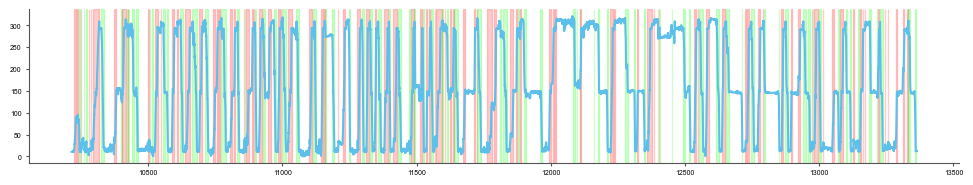

In [185]:
_, ax =  plt.subplots(1, 1, figsize=(12,2), sharex=True)
ax.plot(sess.maze.time, sess.maze.x)
for lap in sess.maze_run.merge_neighbors(5).itertuples():
    color = [1, 0, 0, 0.2] if lap.label == "up" else [0, 1, 0, 0.2]
    ax.axvspan(lap.start, lap.stop, color=color)
# ax.set_xlim([10200, 10500])

Between Group Stats
ZT 0-2.5 Chi2 test on probability p=1.22e-13, w/phi=0.032864034798724566
ZT 0-2.5 Welch t-test on peak probability p = 0.235
ZT 2.5-5 Chi2 test on probability p=2.88e-19, w/phi=0.03642855505964182
ZT 2.5-5 Welch t-test on peak probability p = 0.179
ZT 5-7.5 Chi2 test on probability p=1.73e-16, w/phi=0.026217137432637632
ZT 5-7.5 Welch t-test on peak probability p = 0.294

 Within NSD stats
ZT 0-2.5 vs ZT 2.5-5 Chi2 pvalue=0.00032524614458284695, w/phi=0.012406735519311343
ZT 0-2.5 vs ZT 2.5-5 t-test pvalue=0.4369507188807553
ZT 2.5-5 vs ZT 5-7.5 Chi2 pvalue=0.20054554446317438, w/phi=0.004651589752662922
ZT 2.5-5 vs ZT 5-7.5 t-test pvalue=0.9037506362588696

 Within SD stats
ZT 0-2.5 vs ZT 2.5-5 Chi2 pvalue=0.08859814967130489, w/phi=0.010241542288554107
ZT 0-2.5 vs ZT 2.5-5 t-test pvalue=0.5834387528579731
ZT 2.5-5 vs ZT 5-7.5 Chi2 pvalue=2.4191674816359474e-56, w/phi=0.054662355664210245
ZT 2.5-5 vs ZT 5-7.5 t-test pvalue=0.01771662503399607


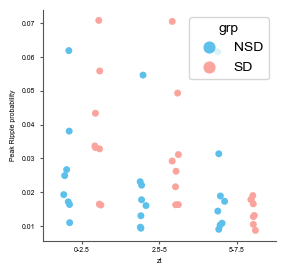

In [33]:
# Plot and run stats
epochs_plot = ["PRE", "0-2.5", "2.5-5", "5-7.5"] if include_pre else ["0-2.5", "2.5-5", "5-7.5"]
# _, ax = plt.subplots(1, 2, figsize=(6, 3))
# sns.stripplot(data=delta_rpl_mod_df, x="zt", y="nripple_peak", hue="grp", dodge=True, ax=ax[0])
# ax[0].set_ylabel("Peak # ripples")
_, ax = plt.subplots(figsize=(3, 3))
sns.stripplot(data=delta_rpl_mod_df, x="zt", y="peak_prob", hue="grp", dodge=True, ax=ax)
ax.set_ylabel("Peak Ripple probability")

print("Between Group Stats")
for zt in epochs_plot:
    nsd_df = delta_rpl_mod_df[(delta_rpl_mod_df.zt == zt) & (delta_rpl_mod_df.grp == "NSD")]
    sd_df = delta_rpl_mod_df[(delta_rpl_mod_df.zt == zt) & (delta_rpl_mod_df.grp == "SD")]
    table = np.array([[nsd_df.nripple_peak.sum(), sd_df.nripple_peak.sum()],
                      [nsd_df.nsw.sum(), sd_df.nsw.sum()]])
    res = stats.chi2_contingency(table)
    tnrip = stats.ttest_ind(nsd_df.nripple_peak.values, sd_df.nripple_peak.values, equal_var=False)
    trip_prob = stats.ttest_ind(nsd_df.peak_prob.values, sd_df.peak_prob.values, equal_var=False)
    # Calculate effect sizes
    w = np.sqrt(res.statistic / np.sum(table.reshape(-1)))
    print(f"ZT {zt} Chi2 test on probability p={res.pvalue:.3g}, w/phi={w}")
    print(f"ZT {zt} Welch t-test on peak probability p = {trip_prob.pvalue:.3g}")

for grp in ["NSD", "SD"]:
    print(f"\n Within {grp} stats")
    for zt1, zt2 in zip(epochs_plot[:-1], epochs_plot[1:]):
        grp_df = delta_rpl_mod_df[delta_rpl_mod_df.grp == grp]
        table = np.array([[grp_df[grp_df.zt == zt1].nripple_peak.sum(), grp_df[grp_df.zt == zt2].nripple_peak.sum()],
                 [grp_df[grp_df.zt == zt1].nsw.sum(), grp_df[grp_df.zt == zt2].nsw.sum()]])
        res = stats.chi2_contingency(table)
        trip_prob = stats.ttest_ind(grp_df[grp_df.zt == zt1].peak_prob.values, 
                                    grp_df[grp_df.zt == zt2].peak_prob.values, equal_var=True)
        # Calculate effect sizes
        w = np.sqrt(res.statistic / np.sum(table.reshape(-1)))
        print(f"ZT {zt1} vs ZT {zt2} Chi2 pvalue={res.pvalue}, w/phi={w}")
        print(f"ZT {zt1} vs ZT {zt2} t-test pvalue={trip_prob.pvalue}")

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: p <= 5.00e-02

2.5-5_NSD vs. 2.5-5_SD: Welch's t-test independent samples, P_val:8.913e-01 t=-1.393e-01
0-2.5_NSD vs. 0-2.5_SD: Welch's t-test independent samples, P_val:6.820e-01 t=-4.187e-01
5-7.5_NSD vs. 5-7.5_SD: Welch's t-test independent samples, P_val:4.665e-01 t=7.566e-01
0-2.5_NSD vs. 5-7.5_SD: Welch's t-test independent samples, P_val:5.181e-01 t=6.661e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 5.00e-02 < p <= 5.00e-02
       *: p <= 5.00e-02

0-2.5_NSD vs. 2.5-5_NSD: t-test paired samples, P_val:8.141e-01 t=2.441e-01
2.5-5_NSD vs. 5-7.5_NSD: t-test paired samples, P_val:1.818e-01 t=-1.482e+00
0-2.5_NSD vs. 5-7.5_NSD: t-test paired samples, P_val:6.198e-01 t=-5.189e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 5.00e-02 < p <= 5.00e-02
       *: p <= 5.00e-02

0-2.5_SD vs. 2.5-5_SD: t-test paired samples, P_va

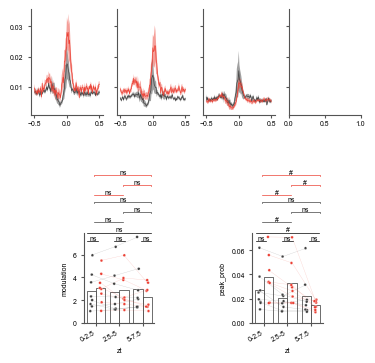

In [4]:
fig = subjects.SdFig().fig1_supp()

subfig = fig.add_subfigure(fig.gs[0, :4])
axs = subfig.subplots(1, 4, sharey=True)

colors = subjects.colors_sd()
epochs_plot = ["PRE", "0-2.5", "2.5-5", "5-7.5"] if include_pre else ["0-2.5", "2.5-5", "5-7.5"]
results_list = []
for i, zt in enumerate(epochs_plot):
    df = delta_rpl_df[delta_rpl_df.zt == zt]

    ax = axs[i]
    for g, grp in enumerate(["NSD", "SD"]):
        df_grp = df[df.grp == grp].groupby("time")
        mean_prob = df_grp.mean(numeric_only=True).reset_index()
        sem_prob = df_grp.sem(ddof=0, numeric_only=True).reset_index()["prob"]

        ax.plot(mean_prob.time, mean_prob["prob"], lw=0.5, color=colors[g])
        ax.fill_between(
            mean_prob.time,
            mean_prob["prob"] - sem_prob,
            mean_prob["prob"] + sem_prob,
            lw=0.5,
            color=colors[g],
            ec=None,
            alpha=0.5,
        )
        # ax.set_ylim(top=0.02)
        # ax.ticklabel_format(axis="y", useMathText=True)

    # sns.lineplot(
    #     data=df, x="time", y="prob", hue="grp", ax=ax, palette=subjects.colors_sd()
    # )
    # ax.legend("", frameon=False)

for idf, feature in enumerate(["modulation", "peak_prob"]):
    ax = fig.subplot(fig.gs[1, idf*2])
    
    p1 = Plotter(
        data=delta_rpl_mod_df, x="zt", y=feature, hue="grp", hue_order=["NSD", "SD"]
    )
    p1.stripbarlineplot_sd(palette=subjects.colors_sd())
    if not include_pre:
        results_list.append(p1.stat_anot_sd(
            stat_across="t-test_welch",
            stat_within="t-test_paired",
            alpha_across=0.05,
            alpha_within=0.05,
            fontsize=5,
            verbose=True,
            prepend=([feature]),
        ))
    else:
        results_list.append(p1.stat_anot_sd(
            stat_across="t-test_welch",
            stat_within="t-test_welch",
            alpha_across=0.05,
            alpha_within=0.05,
            fontsize=5,
            verbose=True,
            prepend=([feature]),
        ))
    # ax.set_ylim(1)

fig.savefig(subjects.figpath_sd / "delta_wave_ripple_prob_norm", format="svg")

In [26]:
results_df = stats_to_df(results_list, prepend=["feature"])
# list(["feature"])
results_df = add_parametric_extras(delta_rpl_mod_df, results_df, "modulation")
results_df.to_csv("/home/nkinsky/Documents/sleep_deprivation/ProcessedData/delta_ripple-modulation_stats.csv")
results_df


Index(['modulation', 'zt', 'nripple_peak', 'nsw', 'peak_prob', 'session',
       'grp'],
      dtype='object')
test-statistics are off by more than merge_thresh - returning pingouin values - compare to results_df_in and re-run


,feature,comp1,comp2,index,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
0,modulation,2.5-5_NSD,2.5-5_SD,T-test,-0.139295,13.452236,two-sided,0.891281,"[-2.04, 1.79]",0.069648,0.43,0.051939
1,modulation,0-2.5_NSD,0-2.5_SD,T-test,-0.418672,13.521612,two-sided,0.682029,"[-1.98, 1.34]",0.209336,0.454,0.067666
2,modulation,5-7.5_NSD,5-7.5_SD,T-test,0.756570,10.158812,two-sided,0.466491,"[-1.26, 2.55]",0.378285,0.519,0.108738
3,modulation,0-2.5_NSD,5-7.5_SD,T-test,0.666125,11.830565,two-sided,0.518110,"[-1.07, 2.0]",0.333063,0.497,0.095295
4,modulation,0-2.5_NSD,2.5-5_NSD,T-test,0.244131,7.000000,two-sided,0.814130,"[-0.44, 0.54]",0.027573,0.345,0.050529
5,modulation,2.5-5_NSD,5-7.5_NSD,T-test,-1.482197,7.000000,two-sided,0.181847,"[-0.6, 0.14]",0.111258,0.755,0.058649
6,modulation,0-2.5_NSD,5-7.5_NSD,T-test,-0.518879,7.000000,two-sided,0.619841,"[-1.0, 0.64]",0.092461,0.376,0.055966
7,modulation,0-2.5_SD,2.5-5_SD,T-test,0.909978,7.000000,two-sided,0.393088,"[-0.4, 0.9]",0.166720,0.469,0.069522
8,modulation,2.5-5_SD,5-7.5_SD,T-test,1.712405,7.000000,two-sided,0.130552,"[-0.21, 1.29]",0.400720,0.947,0.166113
9,modulation,0-2.5_SD,5-7.5_SD,T-test,2.257412,7.000000,two-sided,0.058554,"[-0.04, 1.62]",0.639507,1.688,0.346203


### Delta-off period probability psth across 2.5 hour block

In [6]:
from hfuncs import get_ccg
from scipy.ndimage import gaussian_filter1d

sessions = subjects.ripple_sess()

delta_off_df = []
delta_off_mod_df = []
for s, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs()[2:]

    for e in zt_epochs.itertuples():
        period = [e.start, e.stop]
        sw = sess.delta_wave.time_slice(*period)
        off = sess.off_epochs.time_slice(*period)

        # peak_amp = sw.to_dataframe().peak_amp_zsc
        # end_amp = sw.to_dataframe().stop_amp_zsc
        # delta_amp = np.abs(peak_amp) + np.abs(end_amp)

        sw_t = sw.to_dataframe().peak_time
        off_t = off.to_dataframe().start.values

        t, ccg = get_ccg(sw_t, off_t, 0.005, 1)
        prob = ccg / len(sw_t)
        # ccg = gaussian_filter1d(ccg, sigma=2)
        smth_prob = gaussian_filter1d(prob, sigma=2)
        trough = smth_prob[t < 0].min()
        peak = smth_prob[t > 0].max()

        mean_prob = smth_prob.mean()
        # modulation = (smth_prob.max() - smth_prob.min()) / (
        #     smth_prob.max() + smth_prob.min()
        # )
        # modulation = stats.zscore(smth_prob).max()
        modulation = (peak - trough) / mean_prob

        df = pd.DataFrame(
            dict(
                time=t,
                prob=smth_prob,
                zt=e.label,
                grp=sess.tag,
                session=s,
            )
        )
        mod_df = pd.DataFrame(
            dict(modulation=[modulation], zt=e.label, session=s, grp=sess.tag)
        )

        delta_off_df.append(df)
        delta_off_mod_df.append(mod_df)

delta_off_df = pd.concat(delta_off_df, ignore_index=True)
delta_off_mod_df = pd.concat(delta_off_mod_df, ignore_index=True)

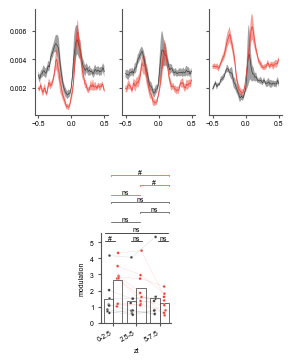

In [7]:
fig = subjects.SdFig().fig1_supp()

subfig = fig.add_subfigure(fig.gs[0, :3])
axs = subfig.subplots(1, 3, sharey=True)

colors = subjects.colors_sd()
for i, zt in enumerate(["0-2.5", "2.5-5", "5-7.5"]):
    df = delta_off_df[delta_off_df.zt == zt]

    ax = axs[i]
    for g, grp in enumerate(["NSD", "SD"]):
        df_grp = df[df.grp == grp].groupby("time")
        mean_prob = df_grp.mean(numeric_only=True).reset_index()
        sem_prob = df_grp.sem(ddof=0, numeric_only=True).reset_index()["prob"]

        ax.plot(mean_prob.time, mean_prob["prob"], lw=0.5, color=colors[g])
        ax.fill_between(
            mean_prob.time,
            mean_prob["prob"] - sem_prob,
            mean_prob["prob"] + sem_prob,
            lw=0.5,
            color=colors[g],
            ec=None,
            alpha=0.5,
        )
        # ax.set_ylim(top=0.02)
        # ax.ticklabel_format(axis="y", useMathText=True)

    # sns.lineplot(
    #     data=df, x="time", y="prob", hue="grp", ax=ax, palette=subjects.colors_sd()
    # )
    # ax.legend("", frameon=False)

ax = fig.subplot(fig.gs[1, 0])

p1 = Plotter(
    data=delta_off_mod_df, x="zt", y="modulation", hue="grp", hue_order=["NSD", "SD"]
)
p1.stripbarlineplot_sd(palette=subjects.colors_sd())
p1.stat_anot_sd(
    stat_across="t-test_welch",
    stat_within="t-test_paired",
    alpha_across=0.05,
    alpha_within=0.05,
    fontsize=5,
)
# ax.set_ylim(1)

fig.savefig(subjects.figpath_sd / "delta_wave_off_prob", format="svg")